In [1]:
# ====================== 环境准备 ======================
# 1) 设定环境变量（必须在导入 matplotlib 之前执行）
import os
from copy import deepcopy
from copy import deepcopy

os.environ['QT_API'] = 'pyqt5'        # 指定使用 PyQt5 作为 Qt 绑定
os.environ['MPLBACKEND'] = 'QtAgg'    # 指定 Matplotlib 后端为 QtAgg（更推荐，替代 TkAgg）

# 2) 启动 Qt 事件循环（控制台模式下，让 Qt 窗口能实时响应）
%gui qt5

# 3) 检查 matplotlib backend
import matplotlib as mpl
mpl.rcParams.update({
    # 这里按系统常见字体给一串候选，存在则自动生效
    "font.sans-serif": ["Microsoft YaHei", "SimHei", "SimSun",
                        "Noto Sans CJK SC", "Source Han Sans SC",
                        "Arial Unicode MS", "DejaVu Sans"],
    "font.family": "sans-serif",
    "axes.unicode_minus": False,   # 负号用正常字符，避免被当作缺字形
})

print("backend (before pyplot):", mpl.get_backend())
# 如果不是 QtAgg，强制改为 QtAgg（注意：必须在导入 pyplot 前设置）
mpl.rcParams['backend'] = 'QtAgg'

# 4) 现在再导入 pyplot
import matplotlib.pyplot as plt
print("backend (after pyplot):", mpl.get_backend())

# ====================== 导入依赖 ======================
import sys
# 避免反复执行时 Qt 类重复导入导致崩溃：如果已加载，先删除再导入
if 'draw.pyqt_draw.pyqt_main2' in sys.modules:
    del sys.modules['draw.pyqt_draw.pyqt_main2']

from PyQt5 import QtWidgets
import pyqtgraph as pg
from draw.pyqt_draw.pyqt_main2 import SatelliteViewer
import draw.read_snap_xml as read_snap_xml

# 配置 pyqtgraph：开启抗锯齿，关闭 OpenGL（更稳定）
pg.setConfigOptions(antialias=True)
# pg.setConfigOptions(useOpenGL=False)   # 若驱动或 OpenGL 有问题可显式关闭
# ====================== 基础参数 ======================
# 星座参数：每轨道卫星数 N，轨道平面数 P
N = 36
P = 18

from config import DATA_DIR,INPUT_DIR


backend (before pyplot): QtAgg
backend (after pyplot): qtagg


In [2]:
from draw.pyqt_draw.pyqt_main2 import SatelliteViewer


In [ ]:
INPUT_DIR

import genaric2.tegnode as tegnode

In [3]:
import genaric2.tegnode as tegnode
import draw.basic_functio.write2xml as write2xml
start_ts =0

end_ts = 1204

file_path = INPUT_DIR / f"onestep/interplane_links_{start_ts}_{end_ts}.xml"
rawnodes = write2xml.xml_to_nodes2(file_path, tegnode.tegnode)
# rawnodes  = write2xml.xml_to_nodes(  rf"E:\研究生\研究进展\工作记录\实验记录\interplane_links_{start_ts}_{end_ts}.xml", tegnode.tegnode)

# 这里，我们读取到nodes 信息,但是我们需要转化为edge信息，注意这里主要就只有包括inter-edge信息


In [4]:
newnodes = deepcopy(rawnodes)

In [5]:
# ====================== 读取数据 ======================
xml_file = r"E:\Data\station_visible_satellites_648_1d_real.xml"

# 解析 XML 得到 group_data，结构：{time_step: {'groups': {...}}}
group_data = read_snap_xml.parse_xml_group_data(xml_file, start_ts, end_ts)

In [ ]:
rev_group_data,offset = read_snap_xml.modify_group_data(group_data, N=36, groupid=4)


In [ ]:
import importlib
importlib.reload(inter_edge2nodes)

In [6]:

# 这里，我们需要将nodes 信息转化为edge信息,注意，这个edge也只有inter-edge，并且是原始
import draw.basic_functio.inter_edge2nodes as inter_edge2nodes
all_inter_edge = inter_edge2nodes.trans_nodes2edges(newnodes,P,N)



C:\Users\yfh\anaconda3\envs\graph_ga\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [7]:
time_2_build = 60
# 这里，我们还需要将pending edges 信息也加入到all_inter_edge 中
pending_edges = inter_edge2nodes.trans_nodes2_pendingedges(newnodes, start_ts, end_ts, time_2_build,P, N)


In [ ]:
newnodes

In [8]:
# 转化为inter-edge信息后，我们可以通过绘图来查看是否是争取的

# ====================== 绘图初始化 ======================
# 1) QApplication 实例（全局唯一）
app = QtWidgets.QApplication.instance() or QtWidgets.QApplication([])

# 2) 确保 viewer 有全局引用，避免 GC 回收导致崩溃
if not hasattr(sys.modules[__name__], "_viewer_list"):
    _viewer_list = []



In [9]:

# 3) 创建并配置 viewer
viewer = SatelliteViewer(group_data)
viewer.setWindowTitle("raw behand")
viewer.resize(1200, 700)
viewer.edges_by_step = all_inter_edge
viewer.pending_links_by_step =pending_edges
viewer.show()



In [ ]:
# 4) 保存全局引用,只要放入到这个容器里，就能持久存在
_viewer_list.append(viewer)

注意，上述的拓扑，是只有异轨链路的，并且，在邻接表上，也是单向的。因此，我们实际上要做这几件事情

1.实际网络拓扑是还有同轨链路的，所以，我们还是要加上同轨链路信息

2.在邻接表上，我们需要将所有的边都转化为双向的

In [ ]:
#添加同轨链路
all_intra_edge = {}
for step in range(start_ts, end_ts):
    all_intra_edge[step] = {}
    for i in range(P):
        for j in range(N):
            nownode = i * N + j
            nextnode = i * N + (j + 1) % N
            upnode = i * N + (j - 1 + N) % N
            all_intra_edge[step].setdefault(nownode, set()).add(nextnode)
            all_intra_edge[step].setdefault(nownode, set()).add(upnode)

In [ ]:
def make_edges_bidirectional(edge_dict):
    """
    edge_dict: {src: set([dst, ...]), ...}
    返回双向邻接表
    """
    new_edges = {}
    for src, dsts in edge_dict.items():
        for dst in dsts:
            new_edges.setdefault(src, set()).add(dst)
            new_edges.setdefault(dst, set()).add(src)
    return new_edges
for step in all_inter_edge:
    all_inter_edge[step] = make_edges_bidirectional(all_inter_edge[step])


为了避免出错，我们可以将所有边都放到一个字典中    然后可以查看下这个图形的对不对

In [ ]:
all_edges = {}

for step in range(start_ts, end_ts):
    all_edges[step] = {}
    # 先合并intra_edge
    if step in all_intra_edge:
        for src, dsts in all_intra_edge[step].items():
            all_edges[step].setdefault(src, set()).update(dsts)
    # 再合并inter_edge
    if step in all_inter_edge:
        for src, dsts in all_inter_edge[step].items():
            all_edges[step].setdefault(src, set()).update(dsts)


In [ ]:
all_inter_edge[1]


 下面是验证下我们的总边是否是对的

In [ ]:

viewer = SatelliteViewer(group_data)
viewer.setWindowTitle("prove the nodes information")
viewer.resize(1200, 700)
viewer.edges_by_step = all_edges
viewer.show()


import genaric2.tegnode as tegnode

至此，我们已经完成了边信息的的转化，接下来，我们就要进行仿真了，第一步的仿真就是平均最短路径。

我们先计算t=1s的时候的平均最短路径长度

In [ ]:
edge_1s = all_edges[1]
edge_1s

可以看到，是符合我们的预期的,接下来，我们就以edge_1s为例子，计算下平均最短路径长度

这里的点呢，以group_data为主，也就是group4 与group0的位置点


In [ ]:
import networkx as nx

# 1. 构造无向图
G = nx.Graph()
for src, dsts in all_edges[1].items():
    for dst in dsts:
        G.add_edge(src, dst)

# 2. 提取 group0 和 group4
group0 = group_data[1]['groups'][0]
group4 = group_data[1]['groups'][4]

# 3. 计算所有 group0 到 group4 的最短距离
path_lengths = []
for n0 in group0:
    for n4 in group4:
        try:
            length = nx.shortest_path_length(G, n0, n4)
            path_lengths.append(length)
        except nx.NetworkXNoPath:
            # 若没有路径，可设为无穷或跳过
            pass

# 4. 计算平均值
if path_lengths:
    avg_length = sum(path_lengths) / len(path_lengths)
else:
    avg_length = float('inf')

print(f"Group0到Group4的平均最短路径长度为: {avg_length:.2f}")


好，比如我们要查看13和324的最短路径

In [ ]:
def node_id_to_ij(node_id, N):
    return (node_id // N, node_id % N)

node_a = 13   # group0里
node_b = 324  # group4里

try:
    path = nx.shortest_path(G, node_a, node_b)
    path_ij = [node_id_to_ij(node, N) for node in path]
    print(f"{node_a}({node_id_to_ij(node_a, N)}) → {node_b}({node_id_to_ij(node_b, N)}) 路径长度 {len(path)-1}:")
    print("    ", " → ".join([f"{node}({ij})" for node, ij in zip(path, path_ij)]))
except nx.NetworkXNoPath:
    print(f"{node_a}({node_id_to_ij(node_a, N)}) → {node_b}({node_id_to_ij(node_b, N)}) 无路径")


接下来，我们可以查看在这段时间内，平均最短路径的变化情况

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

steps = sorted(all_edges.keys())
avg_path_lengths = []
valid_steps = []

for step in steps:
    # 构造无向图
    G = nx.Graph()
    for src, dsts in all_edges[step].items():
        for dst in dsts:
            G.add_edge(src, dst)
    # 取group
    if step not in group_data or 0 not in group_data[step]['groups'] or 4 not in group_data[step]['groups']:
        avg_path_lengths.append(float('nan'))
        continue
    group0 = group_data[step]['groups'][0]
    group4 = group_data[step]['groups'][4]
    # 计算所有点对最短距离
    path_lengths = []
    for n0 in group0:
        for n4 in group4:
            try:
                path_lengths.append(nx.shortest_path_length(G, n0, n4))
            except nx.NetworkXNoPath:
                pass
    if path_lengths:
        avg_length = sum(path_lengths) / len(path_lengths)
        valid_steps.append(step)
    else:
        avg_length = float('nan')
    avg_path_lengths.append(avg_length)

# 可视化
plt.figure(figsize=(10,4))
plt.plot(steps, avg_path_lengths, marker='o')
plt.xlabel('Time Step')
plt.ylabel('Group0↔Group4 平均最短路径长度')
plt.title('区域间平均最短路径随时间变化')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


下面就是可视化的结果，可以看到，变化非常的不平滑。我们猜测，一个重要的原因是，group data本身是时间变化性比较强，同时，整体上存在波动

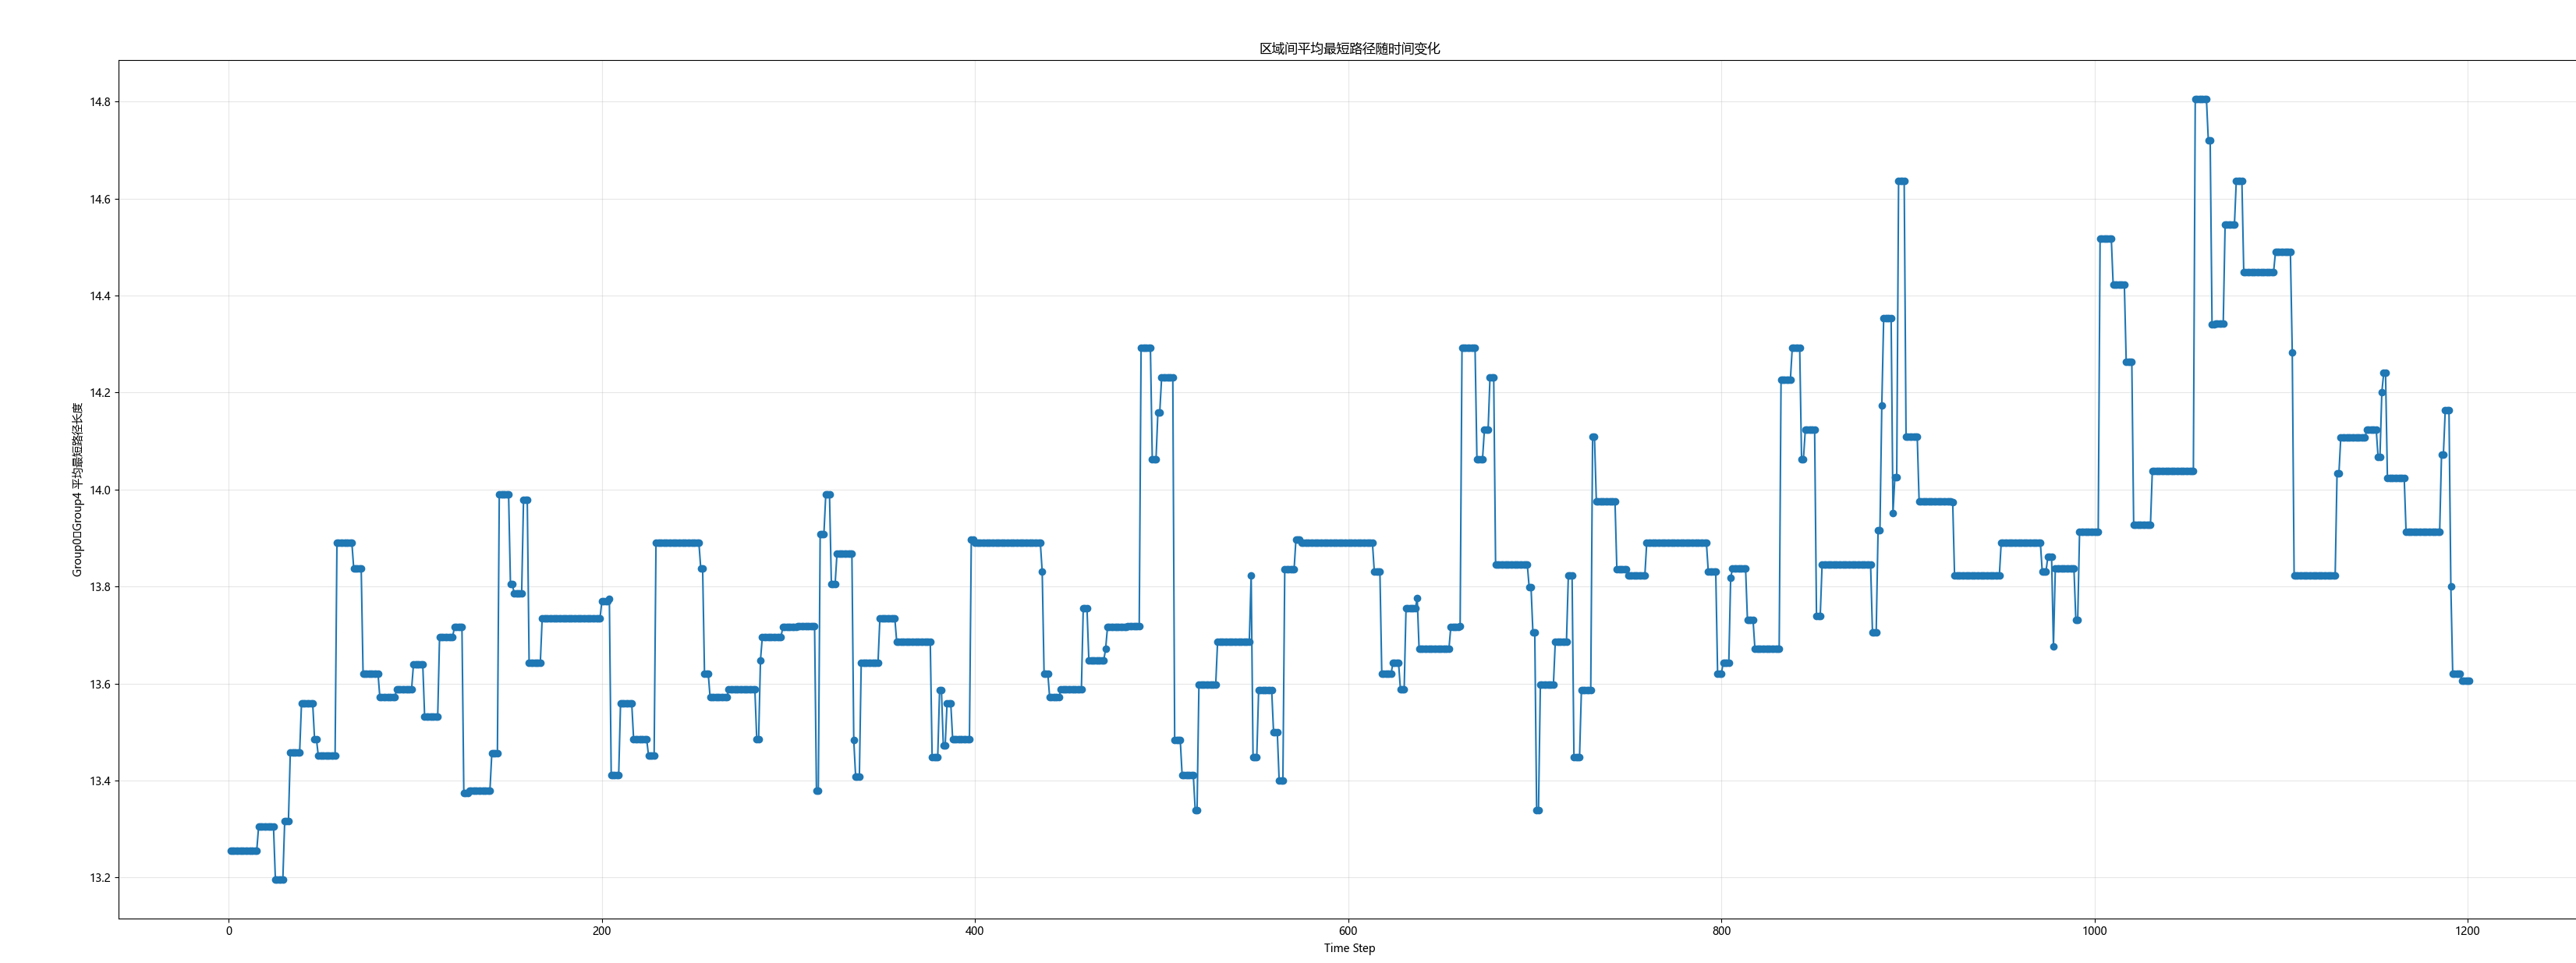

## 写一个包络矩形的平均最短路径变化情况

In [ ]:
## 1.首先，先获得包络矩形内部的节点，

# get the rectangular size of the group
import draw.basic_functio.get_rectangular_size_interval as get_rectangular_size_interval
import importlib
import draw.pyqt_draw.pyqt_onetopology as pyqt_onetopology
importlib.reload(pyqt_onetopology)
# attention,这里要用rev_group_data
t1,t2=get_rectangular_size_interval.calc_envelope_for_group(rev_group_data,[start_ts,end_ts],0,P,N)
t3,t4 = get_rectangular_size_interval.calc_envelope_for_group(rev_group_data,[start_ts,end_ts],4,P,N)
# 3) 下面是同构图设计，我们一般从同构图上设计出 motif，然后，再迁移到我们其他图的显示上去
rects = {
    0: [t1, t2],
    4: [t3, t4],
}


import draw.pyqt_draw.pyqt_onetopology as pyqt_onetopology
viewer = pyqt_onetopology.Onetopology(rects)
viewer.setWindowTitle("testgraph")
viewer.resize(1200, 700)

viewer.show()


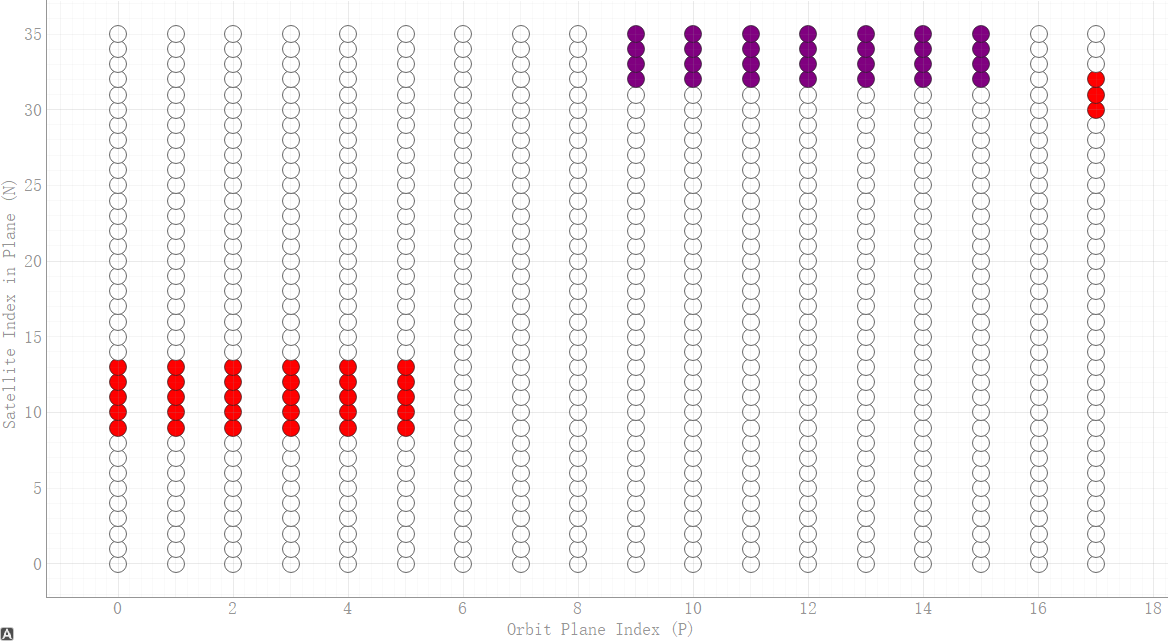

如果是这样的，我们就需要将inter-edge进行变换，变换到我们的同构图上去。

In [ ]:
import draw.basic_functio.edge_revedge as edge_revedge
modify_edge_by_step = edge_revedge.edge2revedge(all_edges, offset)


In [ ]:

# 3) 创建并配置 viewer
viewer = SatelliteViewer(rev_group_data)
viewer.setWindowTitle("prove the nodes information")
viewer.resize(1200, 700)
viewer.edges_by_step = modify_edge_by_step
viewer.show()

# 4) 保存全局引用,只要放入到这个容器里，就能持久存在
_viewer_list.append(viewer)

In [ ]:
rects

In [ ]:
def rect_to_nodes(rect_list, N):
    """rect_list: [(xmin,xmax,ymin,ymax), ...], N: 每轨道卫星数"""
    node_set = set()
    for rect in rect_list:
        if rect is None:
            continue
        xmin, xmax, ymin, ymax = rect
        for x in range(xmin, xmax + 1):
            for y in range(ymin, ymax + 1):
                node_id = x * N + y
                node_set.add(node_id)
    return node_set


group0 = rect_to_nodes(rects[0], N)
group4 = rect_to_nodes(rects[4], N)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

steps = sorted(all_edges.keys())
avg_path_lengths = []
valid_steps = []

for step in steps:
    # 构造无向图
    G = nx.Graph()
    for src, dsts in modify_edge_by_step[step].items():
        for dst in dsts:
            G.add_edge(src, dst)
    # 取group
    if step not in group_data or 0 not in group_data[step]['groups'] or 4 not in group_data[step]['groups']:
        avg_path_lengths.append(float('nan'))
        continue
    # group0 = rev_group_data[step]['groups'][0]
    # group4 = rev_group_data[step]['groups'][4]
    # 计算所有点对最短距离
    path_lengths = []
    for n0 in group0:
        for n4 in group4:
            try:
                path_lengths.append(nx.shortest_path_length(G, n0, n4))
            except nx.NetworkXNoPath:
                pass
    if path_lengths:
        avg_length = sum(path_lengths) / len(path_lengths)
        valid_steps.append(step)
    else:
        avg_length = float('nan')
    avg_path_lengths.append(avg_length)

# 可视化
plt.figure(figsize=(10, 4))
plt.plot(steps, avg_path_lengths, marker='o')
plt.xlabel('Time Step')
plt.ylabel('Group0↔Group4 平均最短路径长度')
plt.title('区域间平均最短路径随时间变化')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
